In [1]:
import sounddevice as sd
import time
import matplotlib.pyplot as plt
from pylab import *
#Parameters--------------
fs = 48*10**3 #48k
duration = 1.45 #seconds

In [2]:
#open all test recordings
import glob
fns = glob.glob("*.np.npy")
sigs = []
ys = []
for fn in fns:
    sigs.append( np.load(fn).flatten() )
    ys.append(fn.split('_')[3])

In [3]:
len(sigs)

44

/home/aadc/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


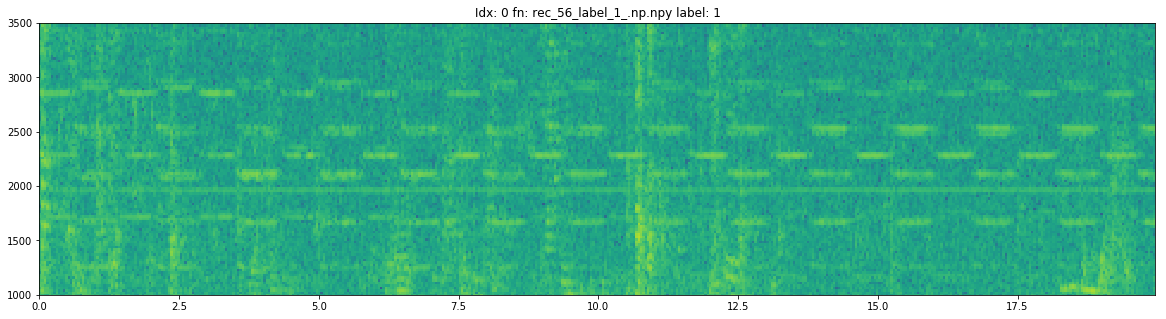

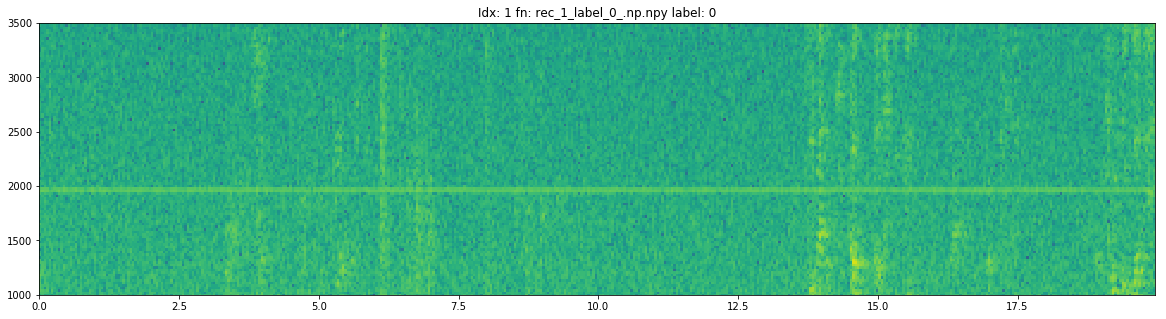

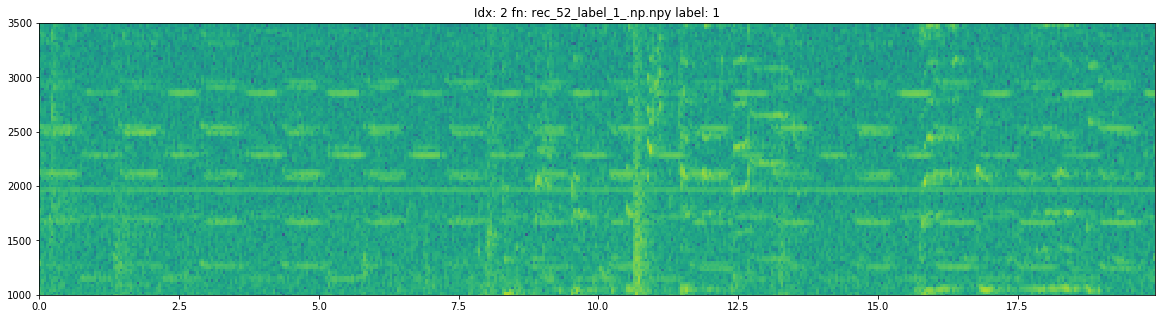

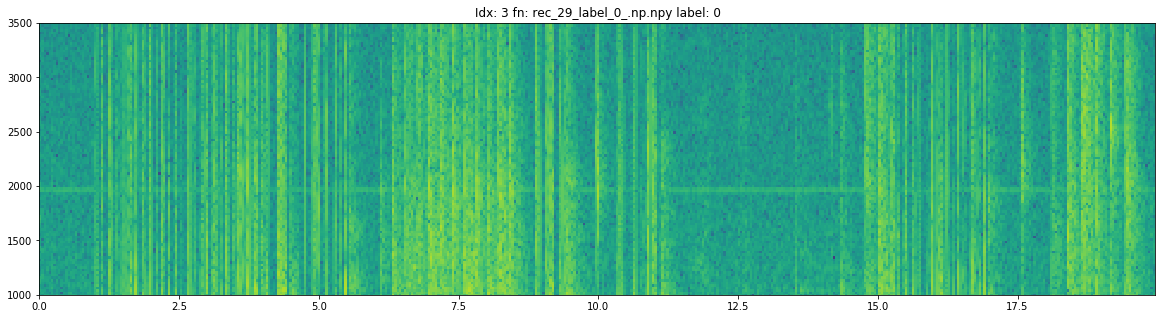

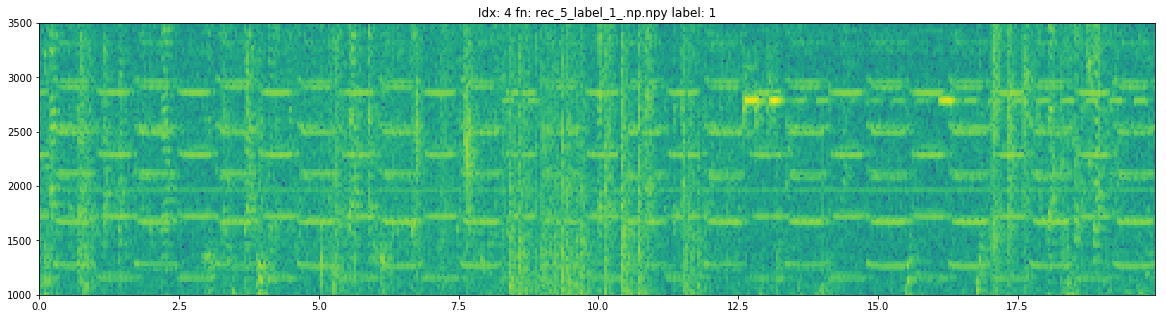

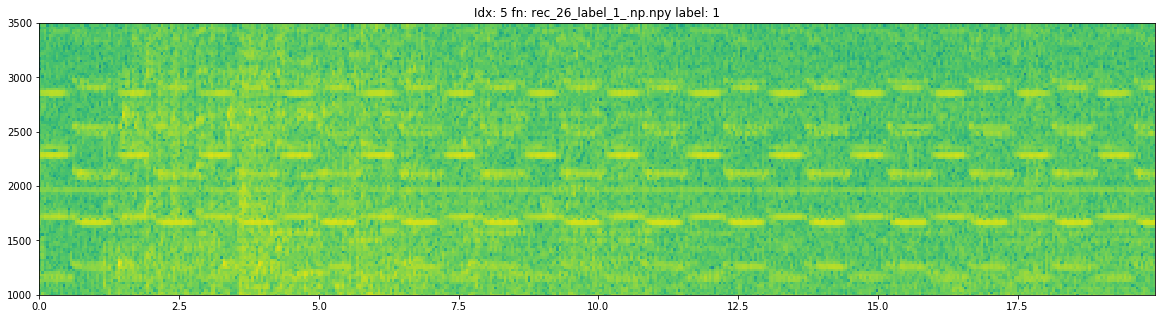

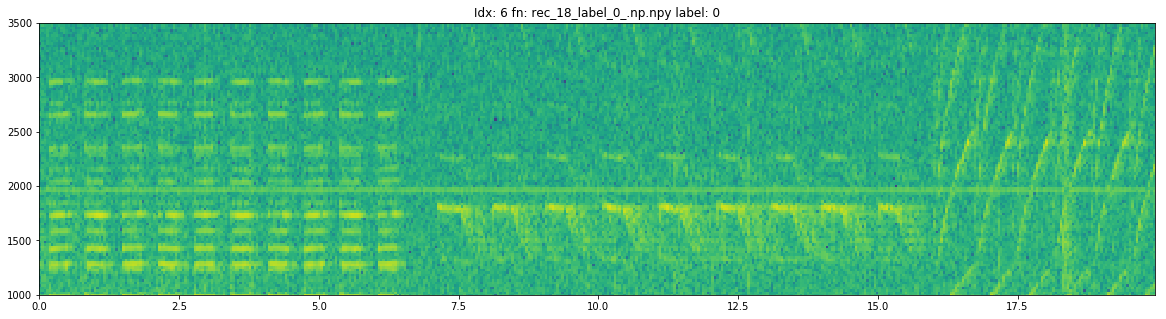

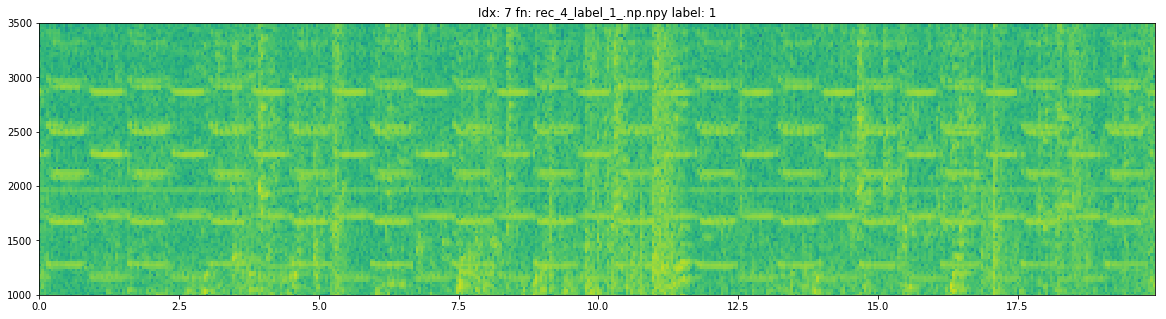

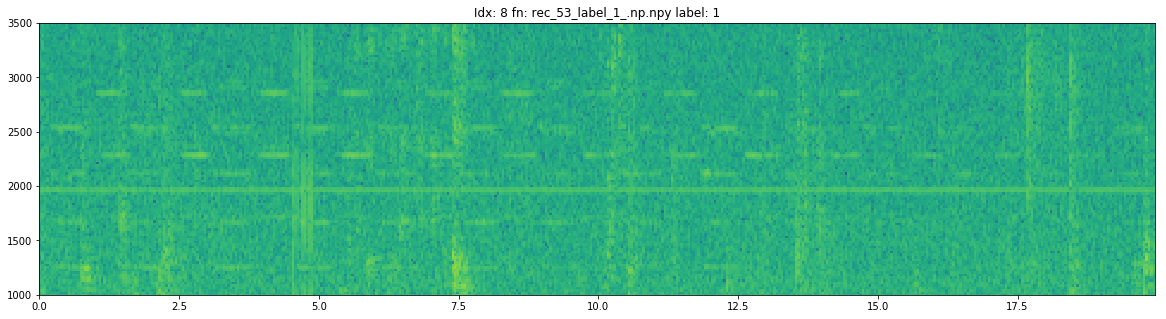

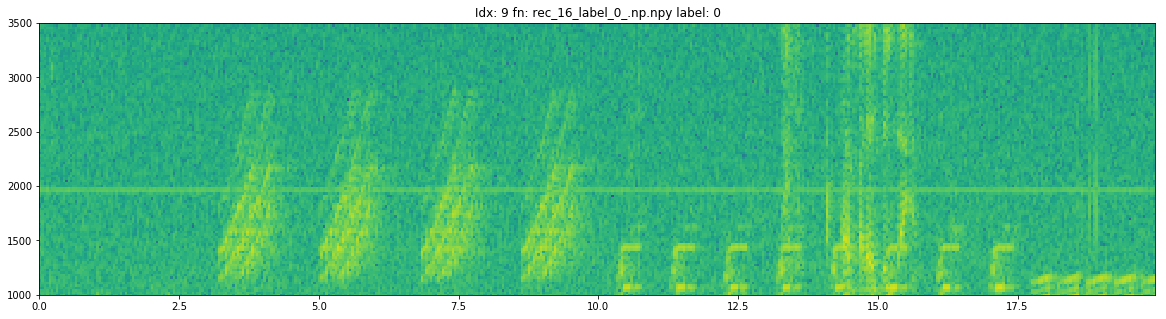

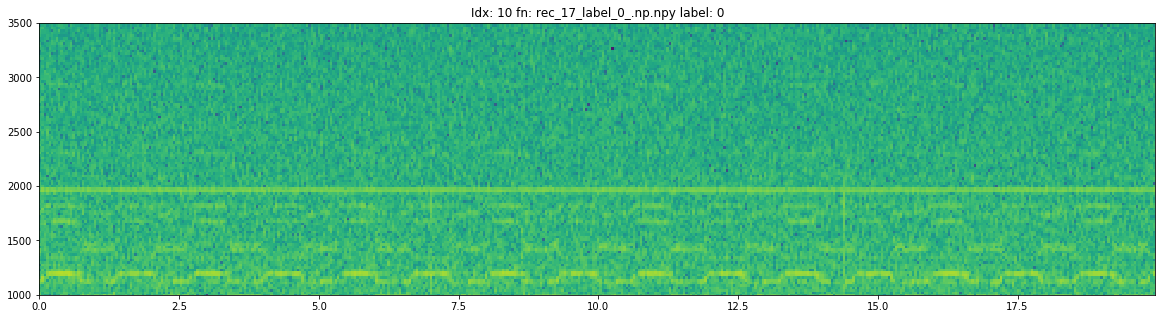

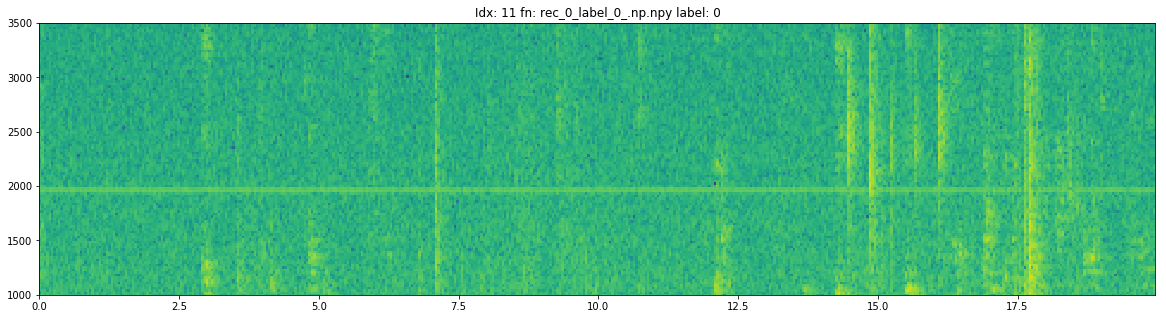

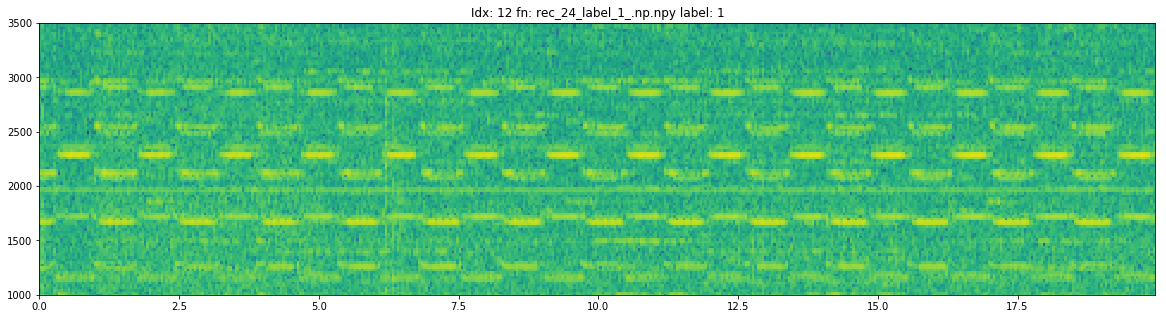

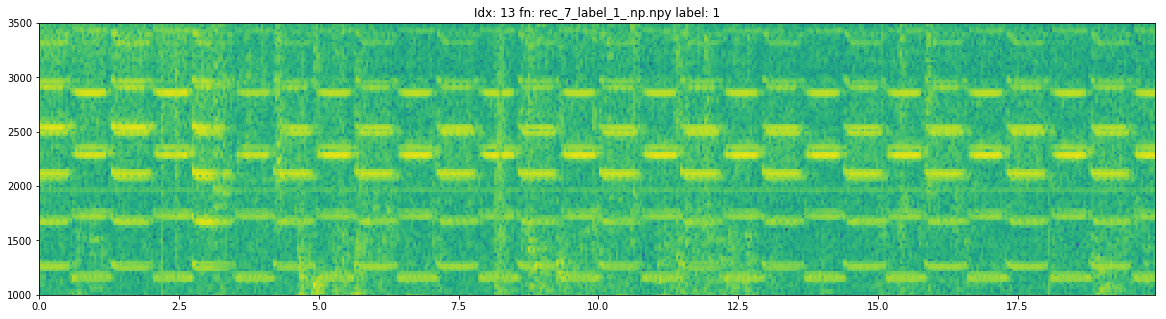

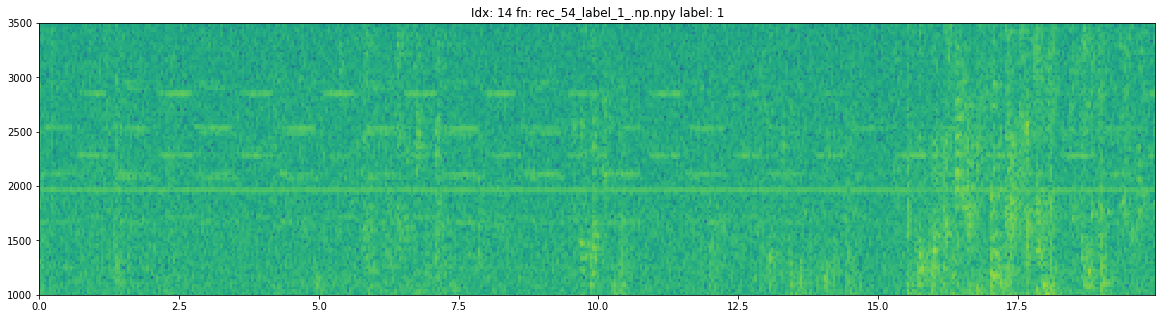

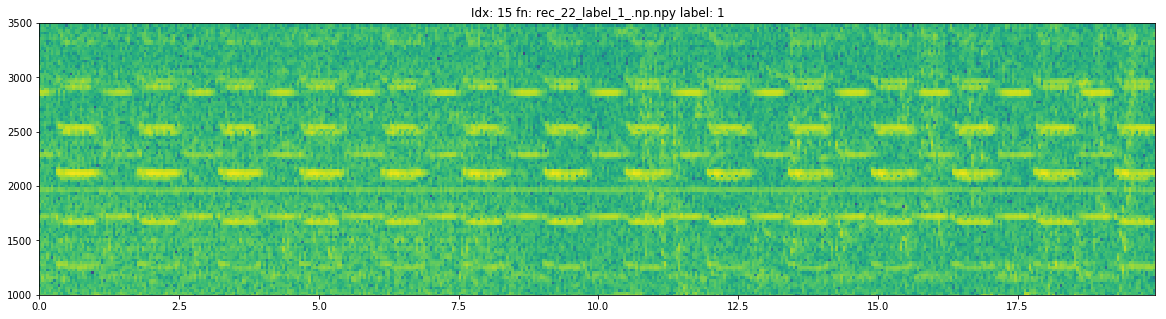

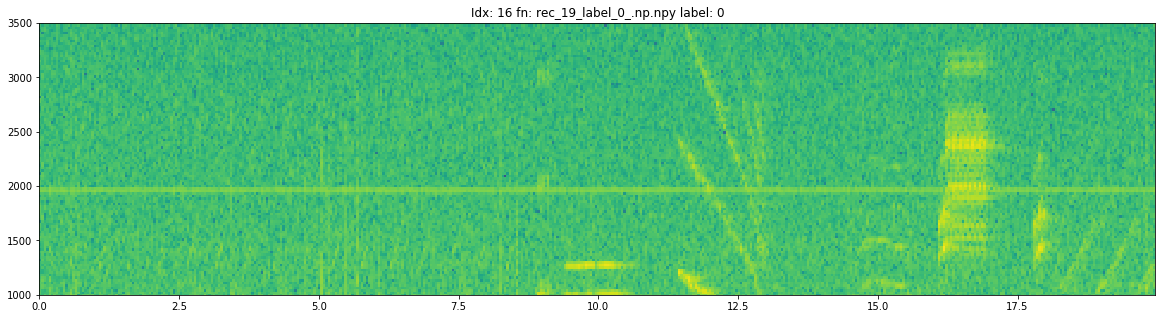

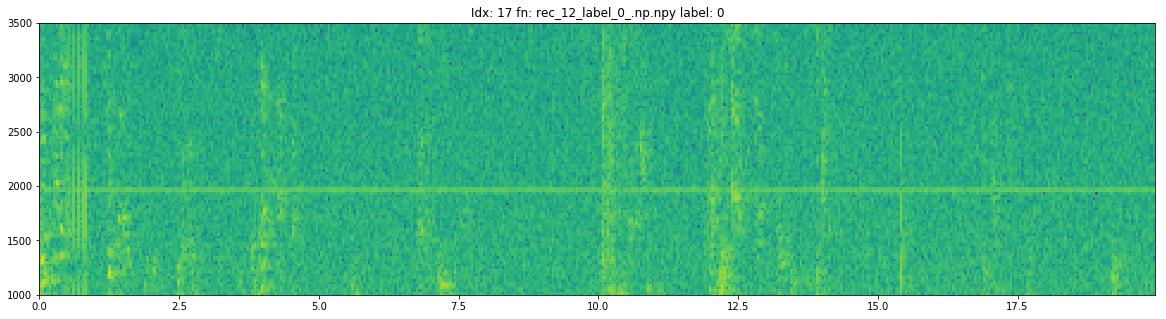

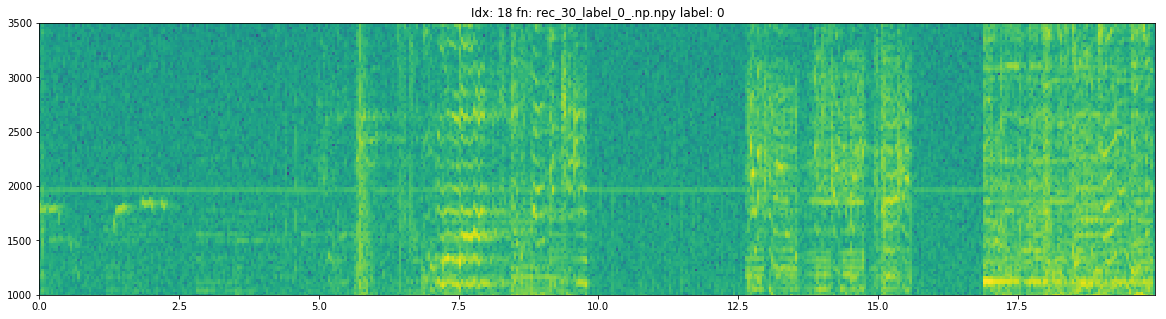

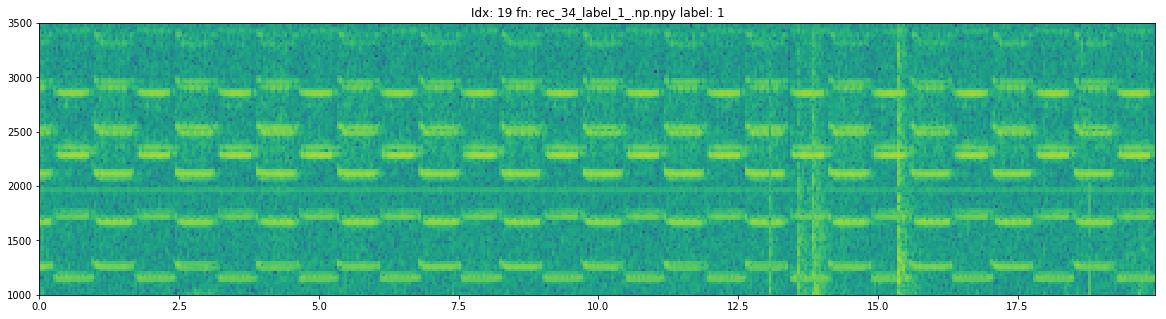

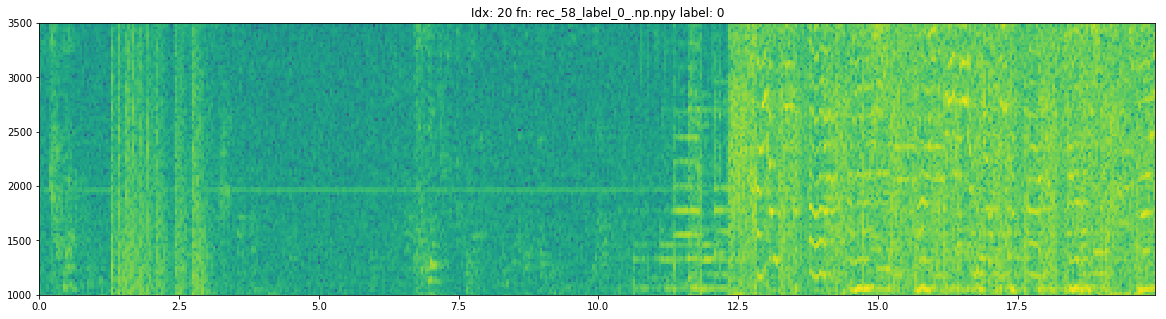

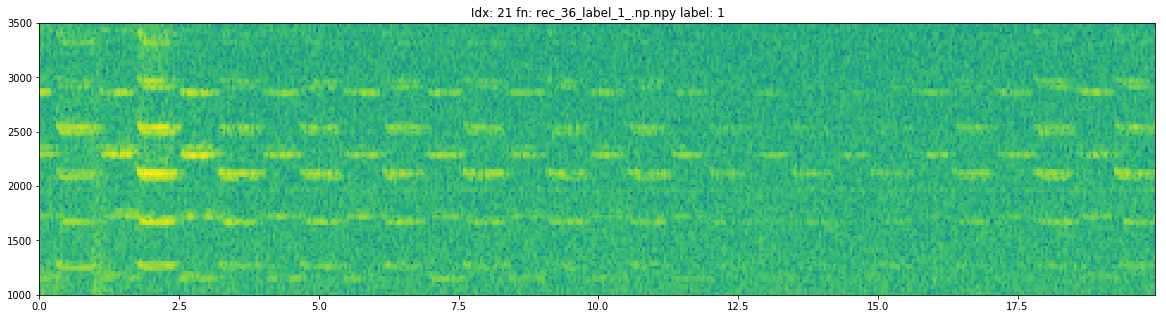

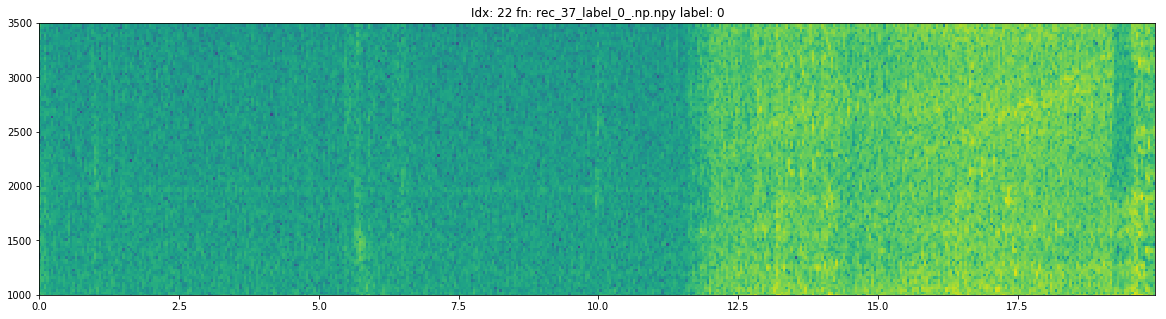

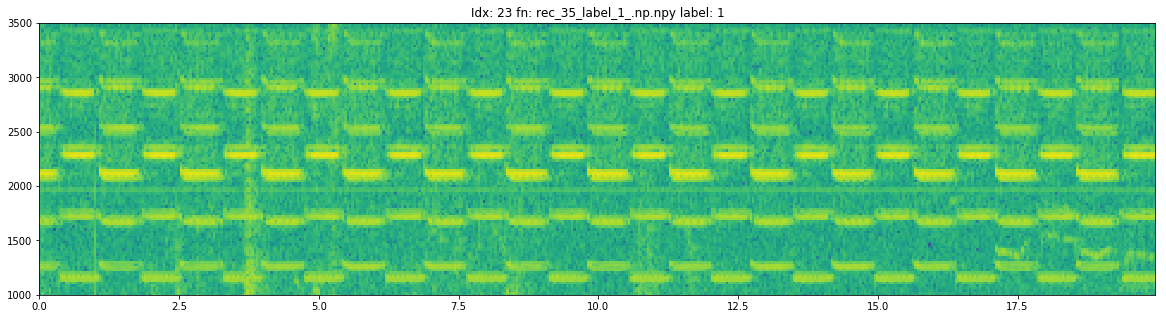

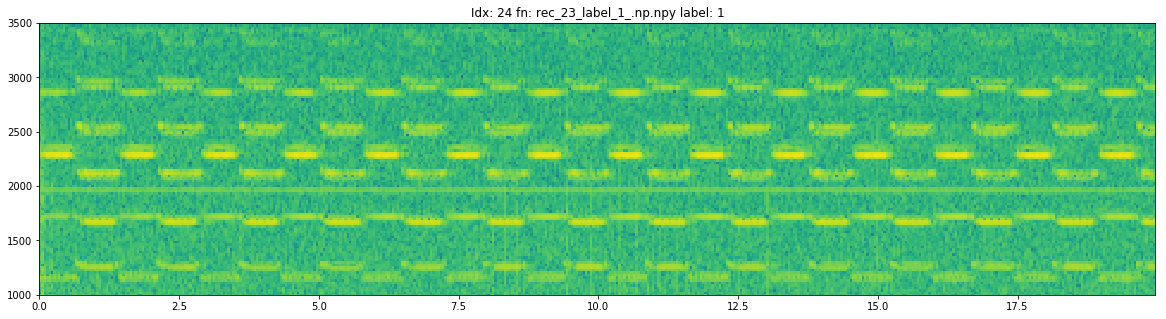

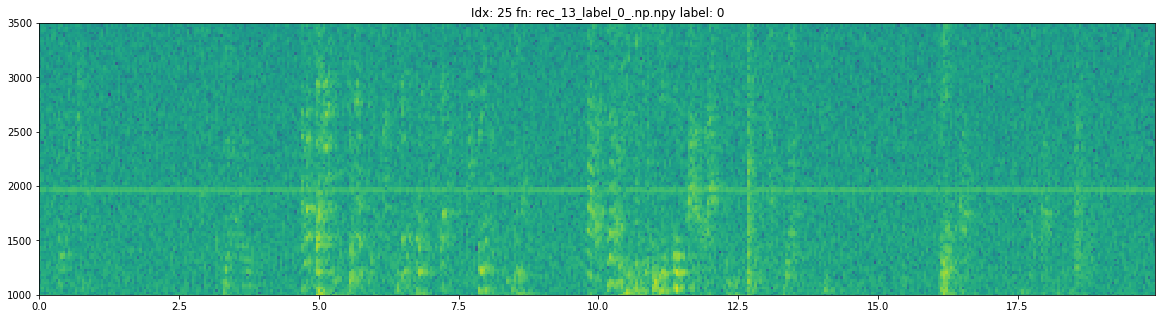

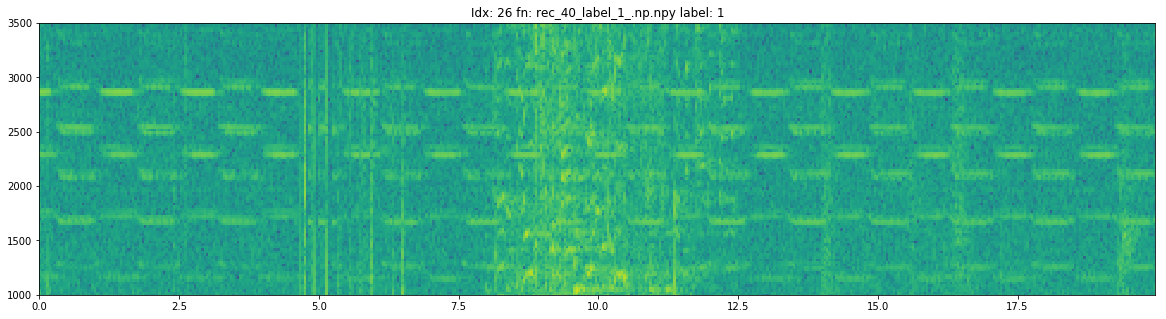

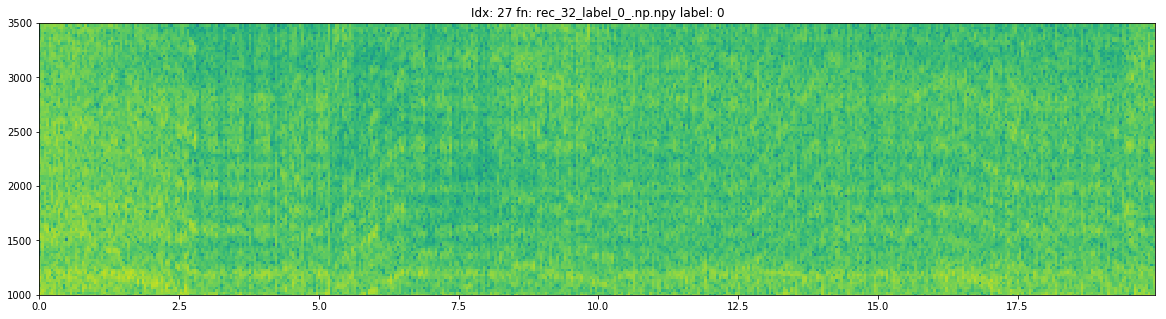

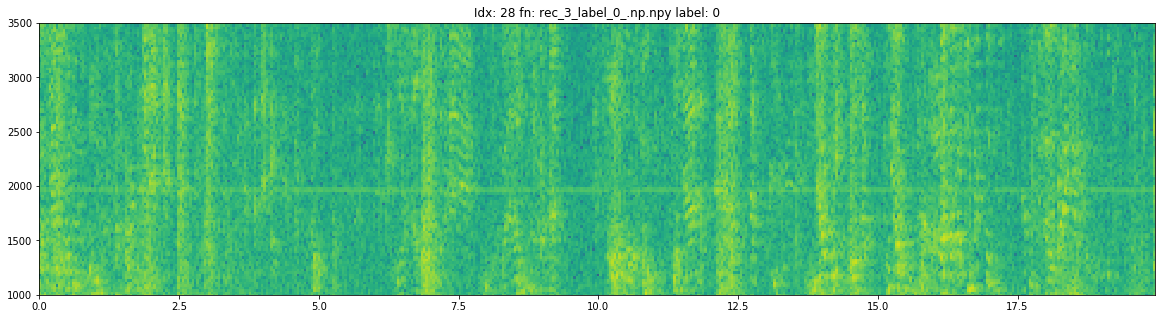

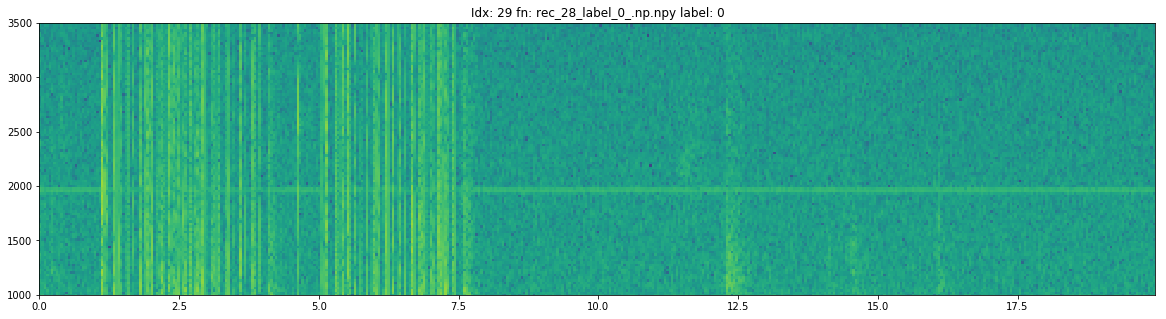

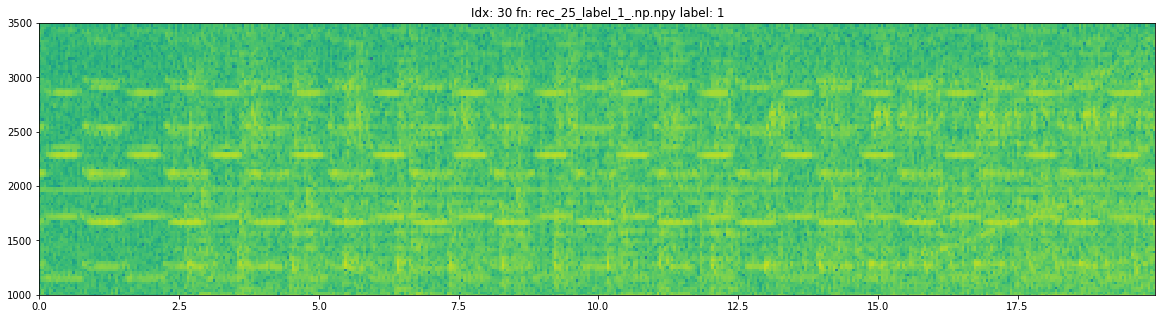

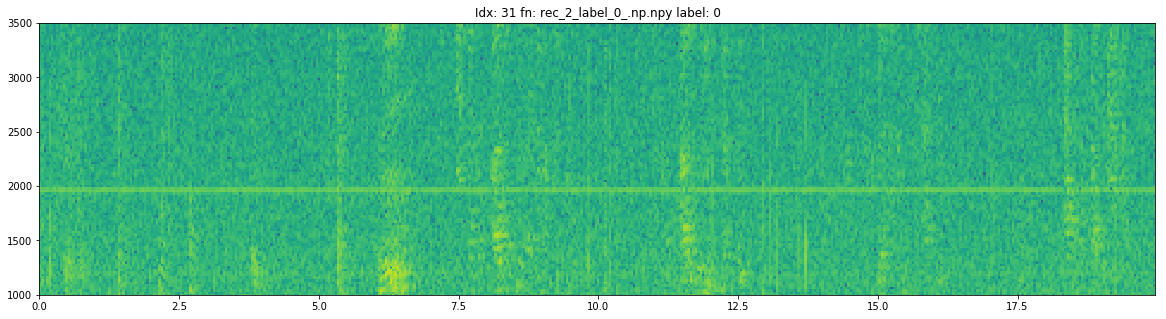

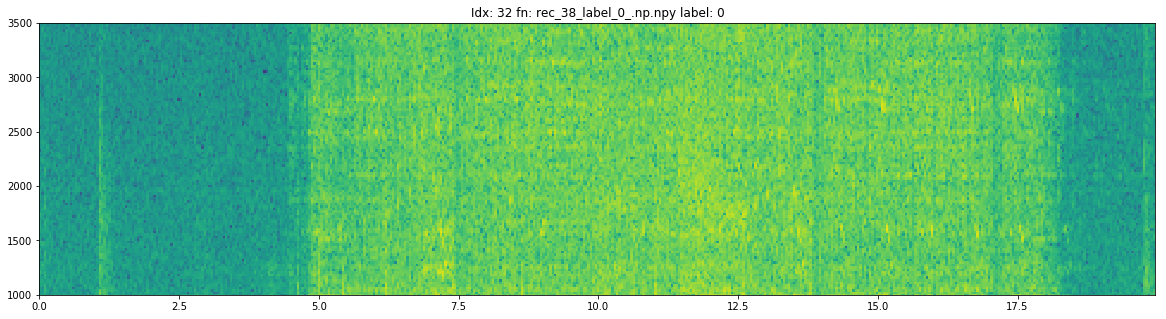

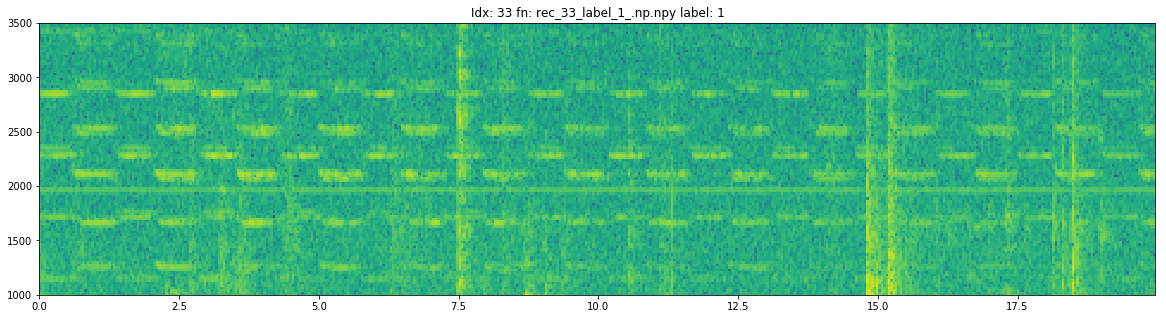

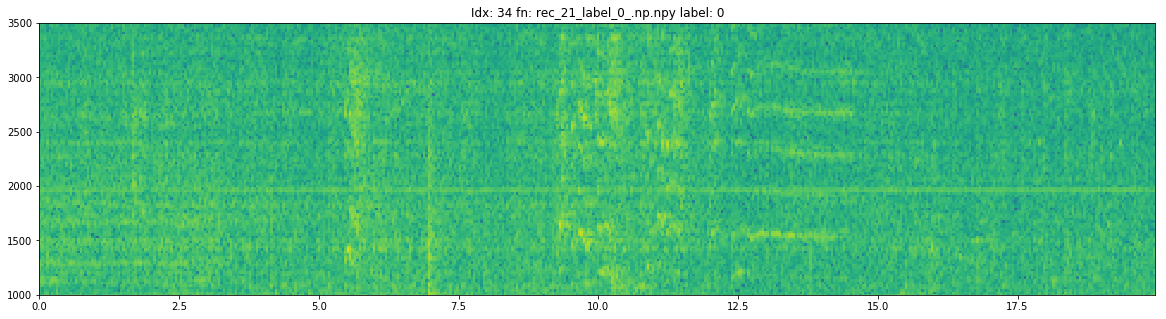

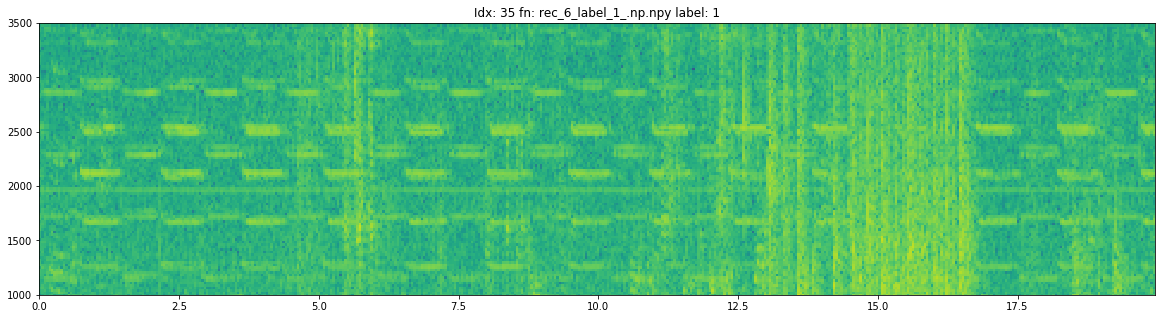

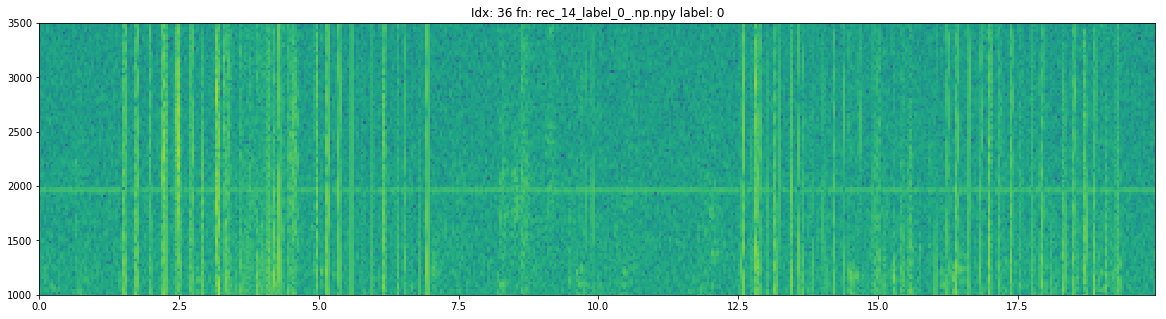

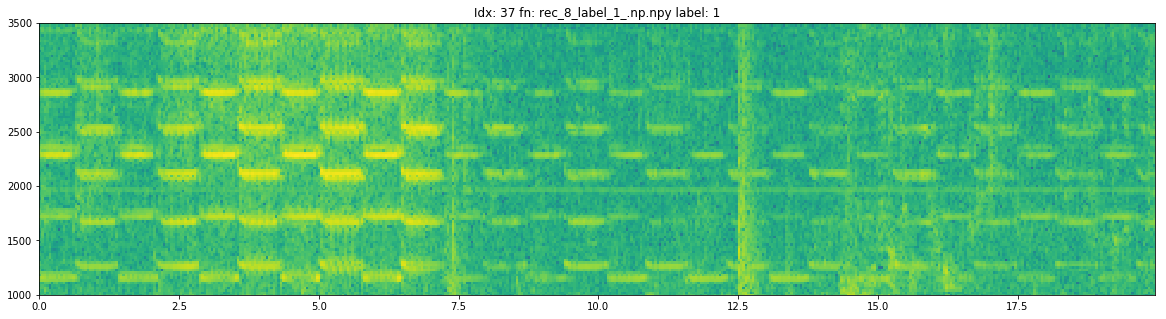

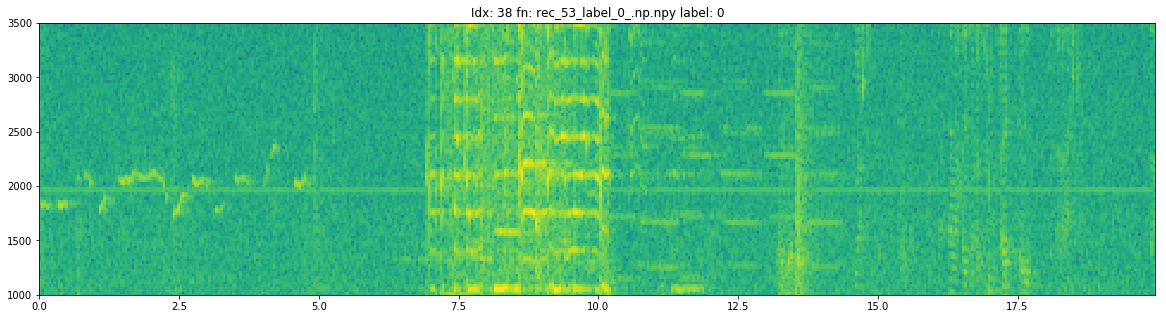

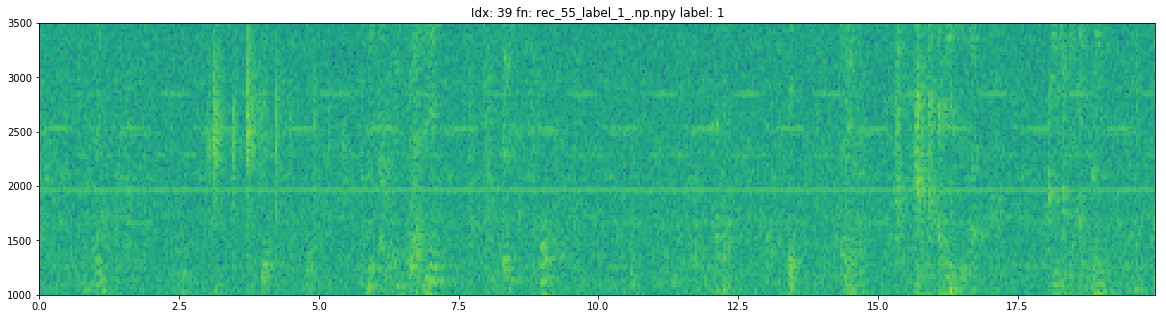

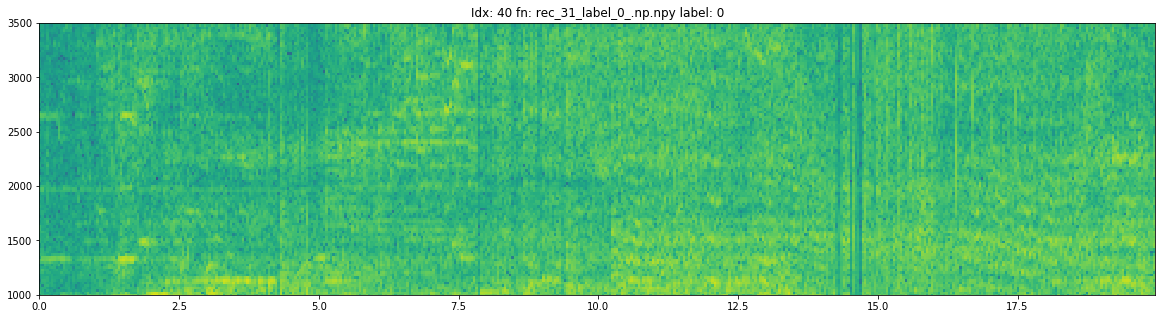

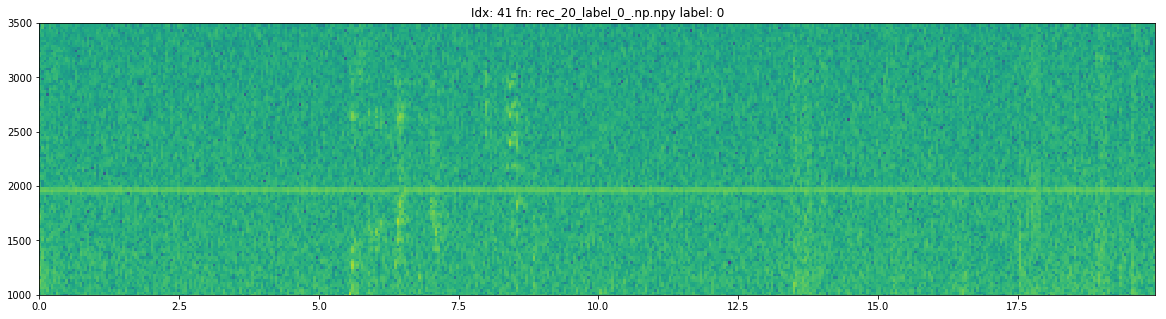

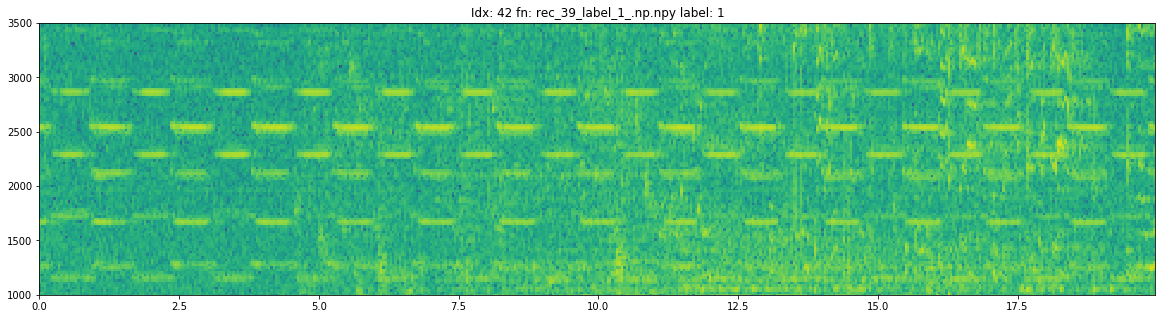

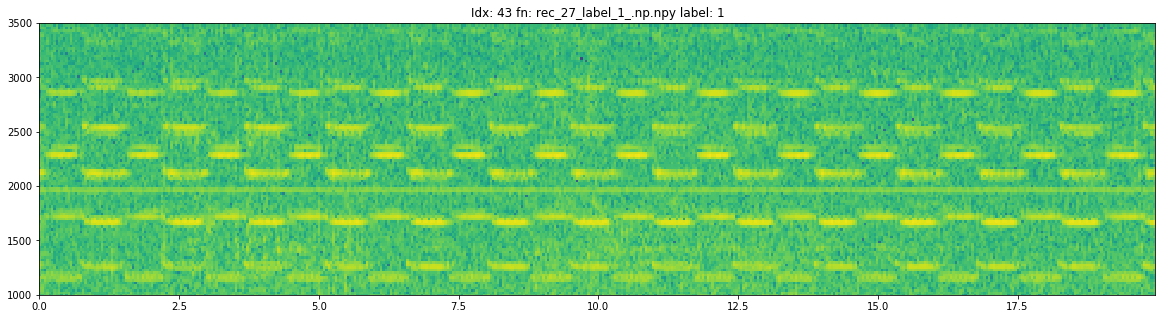

In [4]:
X=[]
y=[]
for nn in range(len(ys)):
    sig = sigs[nn]
    plt.figure(figsize=(20,5))
    spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
    plt.ylim((1000,3500))
    plt.title('Idx: {} fn: {} label: {}'.format(nn,fns[nn],ys[nn]))

    a=[]
    #plt.figure(figsize=(20,5))
    winSize = 1.45 #in seconds
    stepsize=0.1 #in seconds
    offs = 0
    freqidx = (freqs>1000)*(freqs<3000)
    
    l = sum(t<(winSize))
    
    for n, step in enumerate(np.arange(offs,t[-1]-winSize, stepsize)):
        tidx = (t>step).argmax()
        a.append(spectrum[freqidx][:,tidx:tidx+l])
        #plt.subplot(2,9,(n%18)+1)
        #plt.imshow(np.log(a[n]))
        #plt.title(ys[nn])
        
    X.append(a)
    y.append(np.ones(len(a))*int(ys[nn]))
X=np.log(np.asarray(X))
y=np.asarray(y)

In [5]:
sd.play(sigs[34])

In [6]:
sPerFile=X.shape[1] #samples per file
X.shape, y.mean()

((44, 185, 85, 34), 0.5)

In [7]:
X=X.reshape(-1,X.shape[2],X.shape[3])
y=y.reshape(-1)
X.shape

(8140, 85, 34)

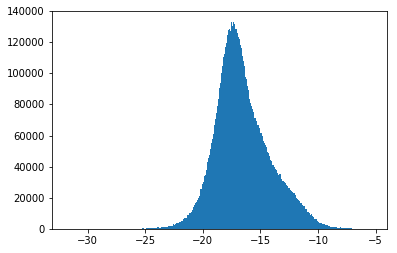

In [8]:
plt.hist(X.flatten(),bins=1000);

In [9]:
# scale all datapoints
print( X.mean(), X.std() )
#X = (X-X.mean())/X.std()
X = (X+15)/3

-16.552087755939873 2.3830025751170587


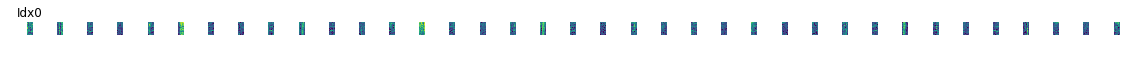

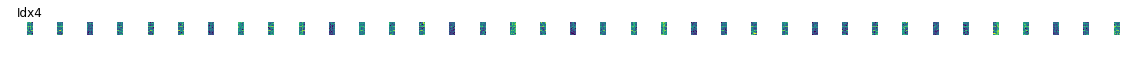

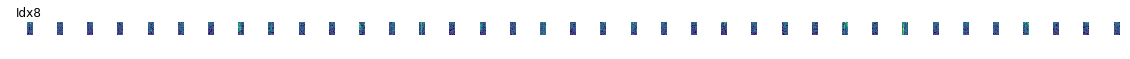

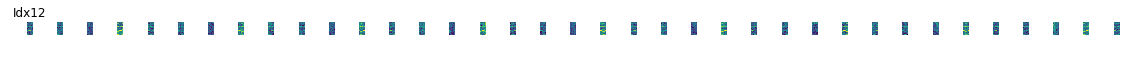

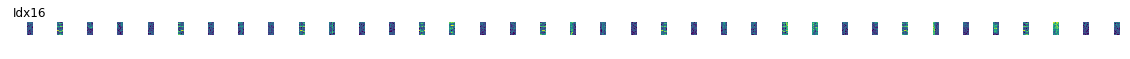

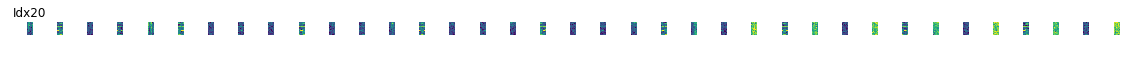

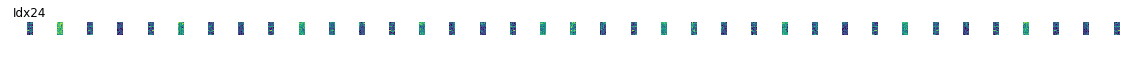

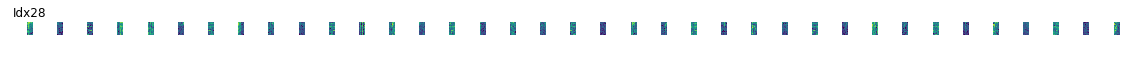

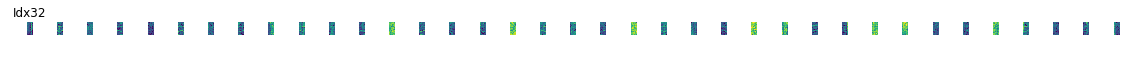

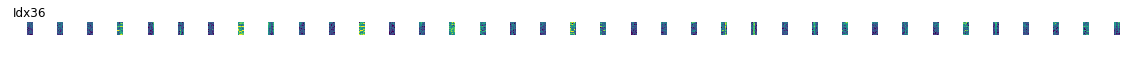

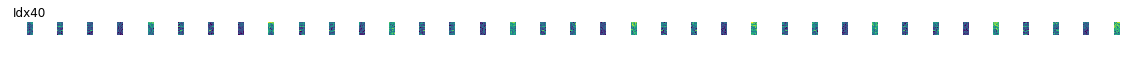

In [10]:
sn = sPerFile
for i in range(0,X.shape[0],20):
    if (i%sn)==0: plt.figure(figsize=(20,4))
    plt.subplot(1,sn,(i%sn)+1)
    plt.imshow((X[i]), vmin=-2,vmax=2)
    if (i%sn)==0:plt.title('Idx'+str(i//sn))
    if (i%sn)==1:plt.title(fns[i//sn])
    if (i%sn)==2:plt.title(ys[i//sn])
    plt.axis('off')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC, NuSVC
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

clfs = [
    LogisticRegression(random_state=42),
    GaussianNB(),
    RandomForestClassifier(n_estimators=701,random_state=1),
    KNeighborsClassifier(n_neighbors=7),
    NuSVC(nu=0.5, kernel='rbf', degree=3),
    GradientBoostingClassifier(n_estimators=701), #,max_depth=6 learning_rate=0.00001
   # MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(128, 4), 
   #                  activation='relu', random_state=1,batch_size=16)
]

Xt = X.reshape(X.shape[0],-1)
Yt = y

for clf in clfs:
    clf_name = str(clf.__class__).split('.')[-1][:-2]
    print(clf_name, '---------------------------')
    %time scores = cross_val_score(clf, Xt, Yt, cv=5, scoring='accuracy')
    print("Val-Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), clf_name))

LogisticRegression ---------------------------
CPU times: user 28.2 s, sys: 1.03 s, total: 29.2 s
Wall time: 28 s
Val-Accuracy: 0.960 (+/- 0.018) [LogisticRegression]
GaussianNB ---------------------------
CPU times: user 1.63 s, sys: 496 ms, total: 2.12 s
Wall time: 2 s
Val-Accuracy: 0.864 (+/- 0.051) [GaussianNB]
RandomForestClassifier ---------------------------
CPU times: user 15min 56s, sys: 256 ms, total: 15min 56s
Wall time: 16min
Val-Accuracy: 0.943 (+/- 0.030) [RandomForestClassifier]
KNeighborsClassifier ---------------------------
CPU times: user 4min 27s, sys: 188 ms, total: 4min 28s
Wall time: 4min 28s
Val-Accuracy: 0.919 (+/- 0.047) [KNeighborsClassifier]
NuSVC ---------------------------
CPU times: user 11min 47s, sys: 232 ms, total: 11min 47s
Wall time: 11min 48s
Val-Accuracy: 0.908 (+/- 0.085) [NuSVC]
GradientBoostingClassifier ---------------------------


In [13]:
clfs[0].fit(Xt,Yt)
from sklearn.externals import joblib
joblib.dump(clfs[0], 'alarm_lr_clf2.pkl')

['alarm_lr_clf2.pkl']

In [ ]:
clfs[2].fit(Xt,Yt)
from sklearn.externals import joblib
joblib.dump(clfs[0], 'alarm_rf_clf.pkl')

In [67]:
clf = clfs[0]
clf.intercept_

array([-0.94667161])

In [12]:
# create model
from keras.models import Sequential
from keras.layers import Dense, Activation, AlphaDropout, Embedding, Dropout, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, Callback
# cnn
from keras.layers import Conv2D, GlobalMaxPooling1D,GlobalAveragePooling1D, MaxPooling2D
from keras.callbacks import EarlyStopping
cb = [EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=5, verbose=1, mode='auto')]

#HYPERPARM:
kernSiz = (30,30)#layer 1 (??has to be devidable be nrDays)
strides = (1,1) #layer 1

cnn = Sequential()
cnn.add(Conv2D(input_shape=(1,X.shape[1],X.shape[2]), filters=256, kernel_size=kernSiz, strides=strides)) 
cnn.add(MaxPooling2D(pool_size=2, strides=None, padding='valid'))
cnn.add(Dropout(0.3))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
cnn.fit(X, y, batch_size=3, epochs=20, verbose=1, validation_split=0.2, callbacks=cb) #silent with verbose

#pred = clf.predict_proba(X_test.reshape(X_test.shape[0],-1,1))[:,0]

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/aadc/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/aadc/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/aadc/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/aadc/anaconda3/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/aadc/anaconda3/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [17]:
Xt.shape

(338, 2890)

In [40]:
import keras
input_shape=(X.shape[1],X.shape[2],1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(13, 13),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(X.reshape(-1,X.shape[1],X.shape[2],1), y,
          batch_size=3,
          epochs=10,
          verbose=1,
          validation_split=0.5)

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/aadc/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/aadc/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/aadc/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/aadc/anaconda3/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/aadc/anaconda3/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: /home/aadc/anaconda3/lib/python3.6/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `CXXABI_1.3.11' not found (required by /home/aadc/anaconda3/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so)


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [75]:
X.shape

(182, 85, 34)

# STUFF

In [ ]:
n=6
sig = sigs[n]
offs=1.6
sig = sig[int(offs*fs):int((offs+1.5)*fs)]
print(ys[n])
spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
plt.ylim((1000,3000))

plt.figure(figsize=(20,5))
intrIdx = [90,98,108]
for idx in intrIdx:
    plt.plot(spectrum[idx,:])

plt.figure(figsize=(20,5))
intrIdx = [90,97,108]
al = []
for idx in intrIdx:
    ff = np.fft.fft(spectrum[idx,:])
    plt.plot(np.abs(ff)) 
    al.append(ff[14])
plt.xlim((0,40))
plt.legend(intrIdx)
#print(al.sum)